In [1]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('data/cleaned_student_lifestyle_dataset.csv')

In [3]:
df.head()

,student_id,study_hours_per_day,extracurricular_hours_per_day,sleep_hours_per_day,social_hours_per_day,physical_activity_hours_per_day,gpa,stress_level,stress_level_numeric,gpa_group
0,1,6.9,3.8,8.7,2.8,1.8,2.99,Moderate,2,2.5-3
1,2,5.3,3.5,8.0,4.2,3.0,2.75,Low,1,2.5-3
2,3,5.1,3.9,9.2,1.2,4.6,2.67,Low,1,2.5-3
3,4,6.5,2.1,7.2,1.7,6.5,2.88,Moderate,2,2.5-3
4,5,8.1,0.6,6.5,2.2,6.6,3.51,High,3,3.5-4


### Hypothesis testing whether ***GPA*** differ with different ***stress levels***

H0: μ1 = μ2 = μ3 (GPA is the same for all stress levels)
___
H1: At least one group mean is different (GPA differs for at least one stress level)

check the normality within each group

In [4]:
from scipy.stats import shapiro
import statsmodels.api as sm

create the function to check normality for each group

In [5]:
def check_normality(group_data, group_name):
    # Shapiro-Wilk test (formal test)
    stat, p_value = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: stat={stat:.4f}, p-value={p_value:.4f}")
    print(f"Data is {'normally distributed' if p_value > 0.05 else 'not normally distributed'}")

    # Visual normality checks
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    # QQ plot
    sm.qqplot(group_data, line='s', ax=ax1)
    ax1.set_title(f"QQ Plot for {group_name} Stress")
    # Histogram
    sns.histplot(group_data, kde=True, ax=ax2)
    ax2.set_title(f"Distribution of GPA for {group_name} Stress")
    ax2.set_xlabel("GPA")
    plt.tight_layout()
    plt.show()

In [6]:
stress_groups = df.groupby('stress_level')

Extract GPA values for each stress level

In [7]:
low_stress = df[df['stress_level'] == 'Low']['gpa']
moderate_stress = df[df['stress_level'] == 'Moderate']['gpa']
high_stress = df[df['stress_level'] == 'High']['gpa']

In [8]:
list(map(np.var, [low_stress, moderate_stress, high_stress]))

[np.float64(0.04623901642689521),
 np.float64(0.048615477815248866),
 np.float64(0.07552953861816836)]

Testing normality assumption:
Shapiro-Wilk test for Low: stat=0.9956, p-value=0.5665
Data is normally distributed


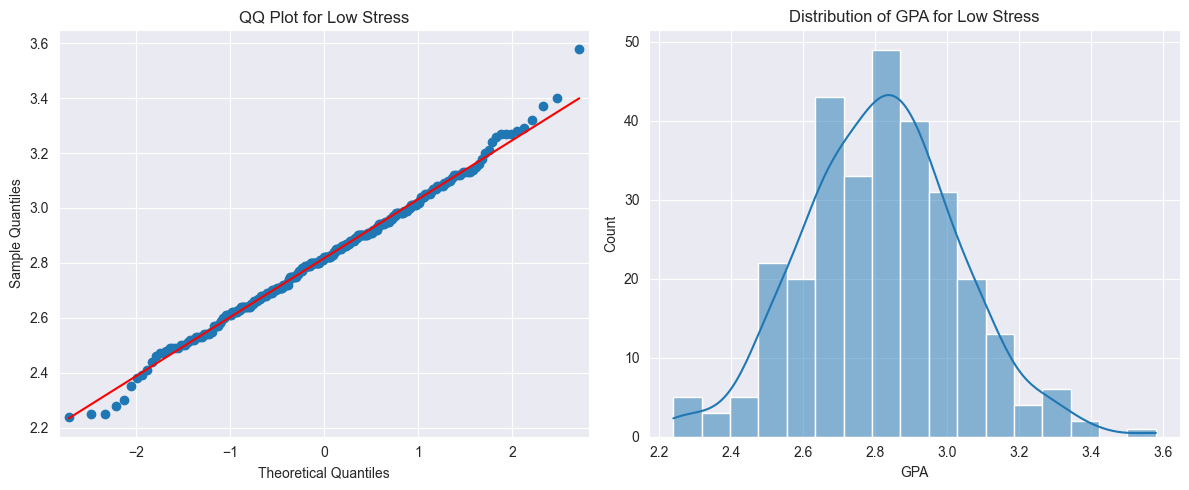

Shapiro-Wilk test for Moderate: stat=0.9961, p-value=0.0979
Data is normally distributed


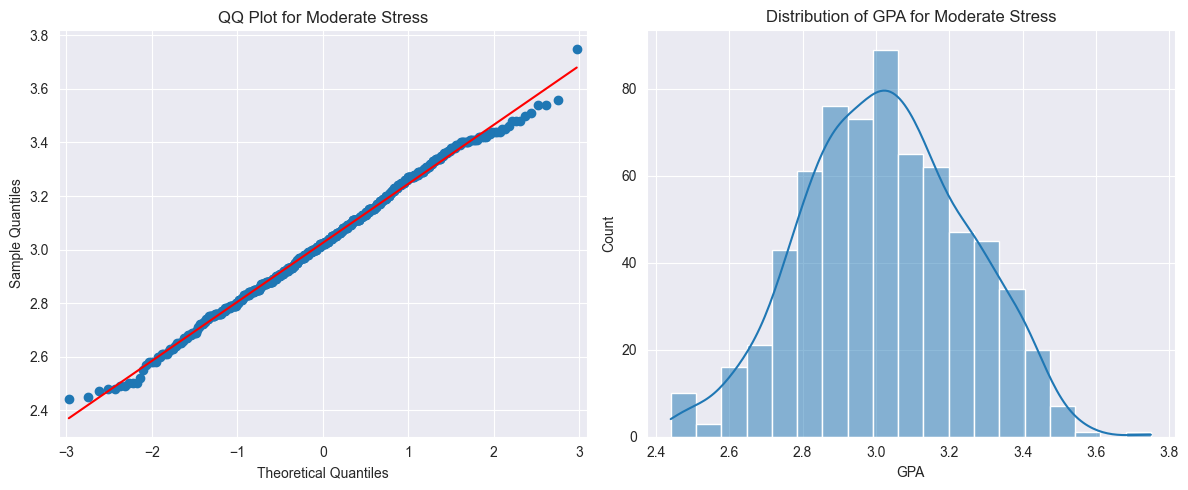

Shapiro-Wilk test for High: stat=0.9941, p-value=0.0004
Data is not normally distributed


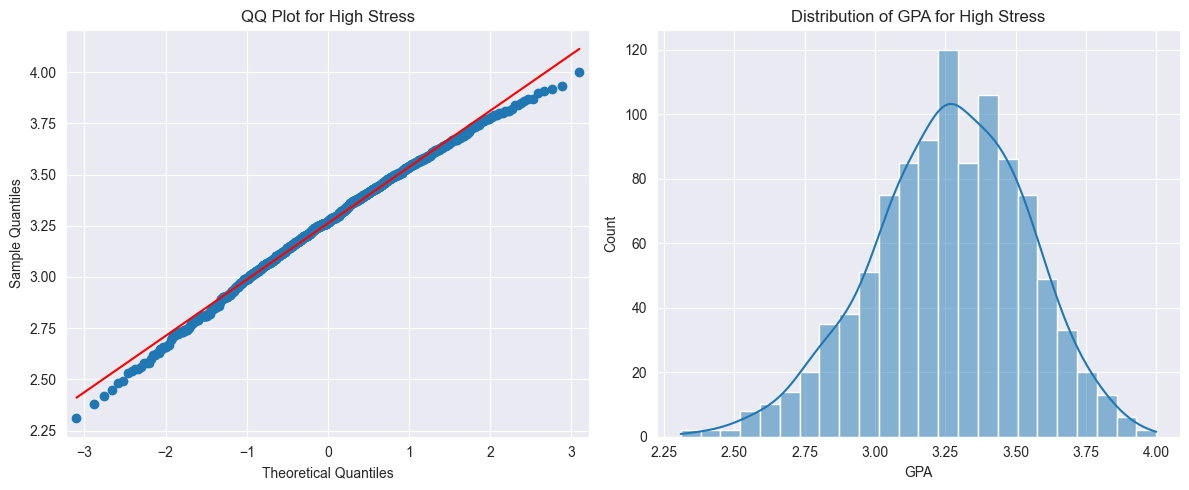

In [9]:
print("Testing normality assumption:")
check_normality(low_stress, "Low")
check_normality(moderate_stress, "Moderate")
check_normality(high_stress, "High")

create the function for checking the homogeneity of variance

In [10]:
from scipy.stats import levene

In [11]:
def check_homogeneity_of_variance(groups):
    stat, p_value = levene(*groups)
    print(f"\nLevene's test for homogeneity of variances:")
    print(f"stat={stat:.4f}, p-value={p_value:.4f}")
    print(f"Variances are {'equal' if p_value > 0.05 else 'not equal'}")

In [12]:
check_homogeneity_of_variance([low_stress, moderate_stress, high_stress])


Levene's test for homogeneity of variances:
stat=21.3722, p-value=0.0000
Variances are not equal


Since the high stress group is not normally distributed and the variances are not equal, we need to apply the Welch's ANOVA test, which is a robust alternative to the one-way ANOVA when the assumptions of normality and homogeneity of variance are violated.

***Welch's ANOVA*** one way ANOVA test

In [13]:
import pingouin as pg

In [14]:
welch_results = pg.welch_anova(dv='gpa', between='stress_level', data=df)

In [15]:
print("\nWelch's ANOVA results:")
print(welch_results)


Welch's ANOVA results:
         Source  ddof1       ddof2           F          p-unc       np2
0  stress_level      2  863.394461  467.654597  2.490879e-138  0.303399


Since the p-value is less than all reasonable alpha (0.01, 0.05, 0.1), we reject the null hypothesis and conclude that there is a significant difference in GPA among the different stress levels.
___
Let's see visualize in order understand where the difference comes from before HCD Tukey's test

/tmp/ipykernel_93128/3492405508.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stress_level', y='gpa', data=df, order=['Low', 'Moderate', 'High'], palette='Set2')


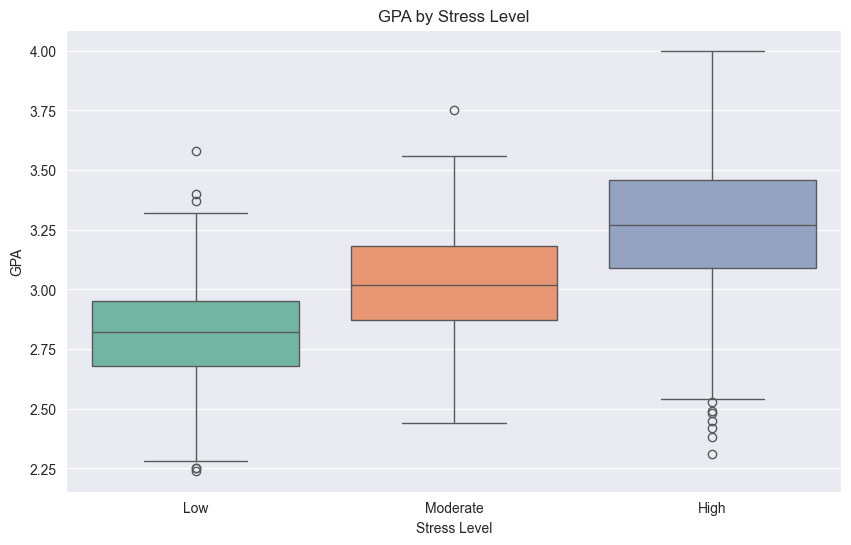

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='stress_level', y='gpa', data=df, order=['Low', 'Moderate', 'High'], palette='Set2')
plt.title('GPA by Stress Level')
plt.xlabel('Stress Level')
plt.ylabel('GPA')
plt.show()


It seems that the means for all groups are different. However, we need to perform a Tukey's test to determine which specific groups are different.

In [17]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

Prepare data in the format needed for Tukey's test

In [18]:
tukey_data = df['gpa'].values
tukey_labels = df['stress_level'].values

Rub Tukey's HSD test

In [19]:
tukey_results = pairwise_tukeyhsd(tukey_data, tukey_labels, alpha=0.05)

In [20]:
print(f"Tukey's HSD test results:\n {tukey_results}")

Tukey's HSD test results:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj  lower   upper  reject
-----------------------------------------------------
  High      Low  -0.4451   0.0 -0.4836 -0.4066   True
  High Moderate  -0.2371   0.0 -0.2661 -0.2081   True
   Low Moderate    0.208   0.0  0.1672  0.2487   True
-----------------------------------------------------


The Tukey's HSD test results show statistically significant differences in GPA between all three stress level groups:

1. **High vs Low stress**: Students with high stress have significantly lower GPAs than those with low stress (mean difference = -0.4451, p < 0.001). This is the largest difference among all comparisons.

2. **High vs Moderate stress**: Students with high stress also have significantly lower GPAs than those with moderate stress (mean difference = -0.2371, p < 0.001).

3. **Low vs Moderate stress**: Students with low stress have significantly higher GPAs than those with moderate stress (mean difference = 0.208, p < 0.001).

**Conclusion**: There is a clear negative relationship between stress level and academic performance. As stress increases from low to moderate to high, GPA significantly decreases at each step. This suggests that stress management might be an important factor in academic success, with the most dramatic impact seen between the low and high stress groups.


### Bootstrapping Analysis

Since we have issues with normality assumptions, let's also perform bootstrapping to estimate confidence intervals for the mean GPA of each stress level and for the differences between groups.


In [21]:
import numpy as np
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

# Number of bootstrap samples
n_bootstrap = 5000

# Function to perform bootstrapping for a single group
def bootstrap_mean(data, n_samples=5000):
    """
    Bootstrap the mean of the input data

    Parameters:
    -----------
    data : array-like
        Input data to bootstrap
    n_samples : int
        Number of bootstrap samples

    Returns:
    --------
    bootstrap_means : array
        Array of bootstrapped means
    """
    bootstrap_means = np.zeros(n_samples)
    for i in range(n_samples):
        # Sample with replacement
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_means[i] = np.mean(sample)
    return bootstrap_means


In [22]:
# Perform bootstrapping for each stress level group
low_stress_means = bootstrap_mean(low_stress, n_bootstrap)
moderate_stress_means = bootstrap_mean(moderate_stress, n_bootstrap)
high_stress_means = bootstrap_mean(high_stress, n_bootstrap)

# Calculate 95% confidence intervals
confidence_level = 0.95
alpha = 1 - confidence_level

print("Bootstrap 95% Confidence Intervals for Mean GPA:")
for name, bootstrap_means in [("Low Stress", low_stress_means),
                              ("Moderate Stress", moderate_stress_means),
                              ("High Stress", high_stress_means)]:
    ci_lower = np.percentile(bootstrap_means, 100 * alpha/2)
    ci_upper = np.percentile(bootstrap_means, 100 * (1 - alpha/2))
    print(f"{name}: {np.mean(bootstrap_means):.4f} [{ci_lower:.4f}, {ci_upper:.4f}]")


Bootstrap 95% Confidence Intervals for Mean GPA:
Low Stress: 2.8170 [2.7925, 2.8413]
Moderate Stress: 3.0248 [3.0081, 3.0416]
High Stress: 3.2619 [3.2451, 3.2793]


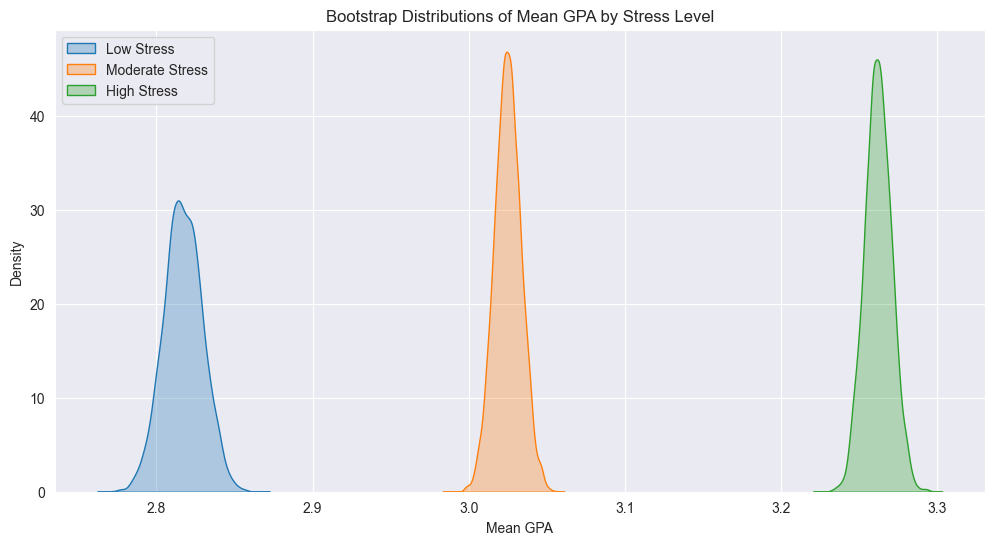

In [23]:
# Plot the bootstrap distributions
plt.figure(figsize=(12, 6))
sns.kdeplot(low_stress_means, label='Low Stress', fill=True, alpha=0.3)
sns.kdeplot(moderate_stress_means, label='Moderate Stress', fill=True, alpha=0.3)
sns.kdeplot(high_stress_means, label='High Stress', fill=True, alpha=0.3)
plt.title('Bootstrap Distributions of Mean GPA by Stress Level')
plt.xlabel('Mean GPA')
plt.ylabel('Density')
plt.legend()
plt.show()


### Bootstrap Analysis of Mean Differences

Now let's estimate the confidence intervals for the differences between groups.


In [24]:
# Calculate pairwise differences between bootstrap samples
low_vs_moderate = low_stress_means - moderate_stress_means
low_vs_high = low_stress_means - high_stress_means
moderate_vs_high = moderate_stress_means - high_stress_means

# Calculate 95% confidence intervals for differences
print("\nBootstrap 95% Confidence Intervals for Mean GPA Differences:")
for name, diff in [("Low - Moderate", low_vs_moderate),
                   ("Low - High", low_vs_high),
                   ("Moderate - High", moderate_vs_high)]:
    ci_lower = np.percentile(diff, 100 * alpha/2)
    ci_upper = np.percentile(diff, 100 * (1 - alpha/2))
    print(f"{name}: {np.mean(diff):.4f} [{ci_lower:.4f}, {ci_upper:.4f}]")
    # Check if confidence interval contains zero (indicates non-significant difference)
    print(f"Statistically significant difference: {not (ci_lower <= 0 <= ci_upper)}")



Bootstrap 95% Confidence Intervals for Mean GPA Differences:
Low - Moderate: -0.2078 [-0.2371, -0.1787]
Statistically significant difference: True
Low - High: -0.4449 [-0.4747, -0.4155]
Statistically significant difference: True
Moderate - High: -0.2371 [-0.2609, -0.2134]
Statistically significant difference: True


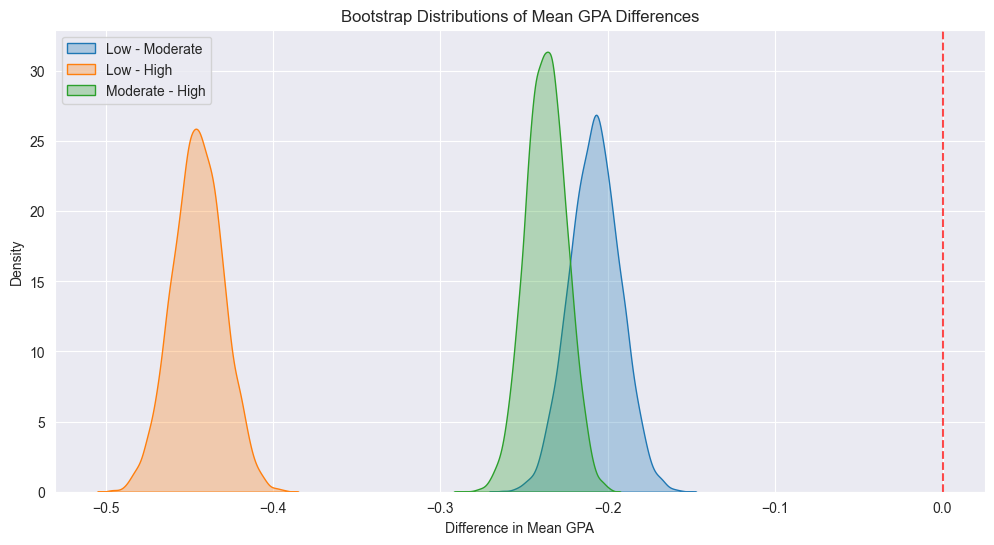

In [25]:
# Plot the bootstrap distributions of differences
plt.figure(figsize=(12, 6))
sns.kdeplot(low_vs_moderate, label='Low - Moderate', fill=True, alpha=0.3)
sns.kdeplot(low_vs_high, label='Low - High', fill=True, alpha=0.3)
sns.kdeplot(moderate_vs_high, label='Moderate - High', fill=True, alpha=0.3)
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
plt.title('Bootstrap Distributions of Mean GPA Differences')
plt.xlabel('Difference in Mean GPA')
plt.ylabel('Density')
plt.legend()
plt.show()


### Bootstrap Hypothesis Testing

Let's also perform bootstrap hypothesis testing for the differences between groups.


In [26]:
def bootstrap_p_value(group1, group2, n_bootstrap=5000):
    """
    Calculate bootstrap p-value for testing the null hypothesis that the means are equal

    Parameters:
    -----------
    group1, group2 : array-like
        Input data for both groups
    n_bootstrap : int
        Number of bootstrap samples

    Returns:
    --------
    p_value : float
        Bootstrap p-value
    """
    # Observed difference in means
    observed_diff = np.mean(group1) - np.mean(group2)

    # Combine data under the null hypothesis
    combined = np.concatenate([group1, group2])

    # Count how many bootstrap differences are more extreme than observed
    n_extreme = 0
    for _ in range(n_bootstrap):
        # Resample from combined data
        bootstrap_group1 = np.random.choice(combined, size=len(group1), replace=True)
        bootstrap_group2 = np.random.choice(combined, size=len(group2), replace=True)

        # Calculate bootstrap difference in means
        bootstrap_diff = np.mean(bootstrap_group1) - np.mean(bootstrap_group2)

        # Check if more extreme than observed (two-tailed test)
        if abs(bootstrap_diff) >= abs(observed_diff):
            n_extreme += 1

    return n_extreme / n_bootstrap


In [27]:
# Calculate bootstrap p-values for each comparison
print("\nBootstrap Hypothesis Tests (null hypothesis: equal means)")
comparisons = [
    ("Low vs Moderate", low_stress, moderate_stress),
    ("Low vs High", low_stress, high_stress),
    ("Moderate vs High", moderate_stress, high_stress)
]

for name, group1, group2 in comparisons:
    p_value = bootstrap_p_value(group1, group2, n_bootstrap)
    print(f"{name}: p-value = {p_value:.4f}, {'Significant' if p_value < 0.05 else 'Not significant'}")



Bootstrap Hypothesis Tests (null hypothesis: equal means)
Low vs Moderate: p-value = 0.0000, Significant
Low vs High: p-value = 0.0000, Significant
Moderate vs High: p-value = 0.0000, Significant


### Comparison of Results: Traditional Tests vs. Bootstrapping

The bootstrapping analysis confirms the findings from the Welch's ANOVA and Tukey's HSD tests:

1. The bootstrap confidence intervals for mean GPA show clear separation between the three stress level groups.
2. The bootstrap confidence intervals for the differences between groups do not contain zero, indicating statistically significant differences.
3. The bootstrap hypothesis tests yield very small p-values, providing further evidence of significant differences between all stress level groups.

So, bootstrap also shows that the differences in GPA among the stress levels are statistically significant (for all groups), confirming the results from the traditional ANOVA and Tukey's tests.

